# Método Clarke e Wright

1. Obter as distâncias entre todos os nós i e j e destes até o depósito D;
2. Calcular os ganhos de cada par (i , j) e D;
3. Ordenar os pares (i , j), de forma decrescente, segundo os valores dos ganhos gi,j;
4. Para cada par (i , j), tirado da seqüência de combinações, verificar se os dois pontos já fazem parte de um roteiro iniciado;
5. Verificar se o roteiro atende as restrições de tempo e capacidade;
6. Continuar até incluir todos os pontos.

$D_{ij} = \sqrt{(X_{i} - X{j})^2 + (Y_{i} - Y{j})^2}$

$g_{ij} = D_{di} + D_{dj} - D_{ij}$

# Dados iniciais 

|   |X | Y|
|:-:|-:|-:|
|Dep|00.00|00.00|
|1  |13.92|35.98|
|2  |17.20|26.39|
|3  |51.69|12.46|
|4  |99.92|70.68|
|5  |43.78|66.82|
|6  |50.92|40.80|
|7  |09.04|75.68|
|8  |80.22|04.02|
|9  |64.82|55.67|
|10 |38.51|03.19|

Mais informações: http://web.mit.edu/urban_or_book/www/book/chapter6/6.4.12.html

In [1]:
from IPython.display import display
from matplotlib import pyplot as plt
import io
import numpy as np
import pandas as pd
import matplotlib.path as mplPath

%matplotlib inline

In [2]:
def plot_base(df: pd.DataFrame):
    plt.figure(figsize=(6, 2))
    plt.plot(df.x, df.y, 'o')
    plt.title('Routes')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid()
    plt.xticks(np.arange(min(df.x), max(df.x)+1, 5))
    plt.yticks(np.arange(min(df.y), max(df.y)+1, 10))

In [3]:
def get_next_pair(df: pd.DataFrame, drop=False) -> tuple:
    k = df.index[0]
    if drop:
        df.drop(k, axis=0, inplace=True)
    return map(int, k.split('_'))

In [4]:
def connect_points(df: pd.DataFrame, path: list):
    plt.plot(
        df.iloc[path].x, df.iloc[path].y
    )

In [5]:
def check_all_points_satisfied(
    routes: list, n_points: int
) -> bool:
    return sum([len(r)-2 for r in routes]) >= n_points

In [6]:
def check_route_constraint_violated(route: list, k1: int, k2: int):
    # initial validate
    if not route:
        return False
    
    """
    a. Either, neither i nor j have already been assigned 
    to a route, in which case a new route is initiated including 
    both i and j.
    """
    if k1 in route and k2 in route:
        return True
    
    """
    b. Or, exactly one of the two points (i or j) 
    has already been included in an existing route and 
    that point is not interior to that route 
    (a point is interior to a 'route if it is not adjacent 
    to the depot D in the order of traversal of points), 
    in which case the link (i, j) is added to that same route.
    """
    if not (
        route[1] == k1 or route[-2] == k1 or
        route[1] == k2 or route[-2] == k2
    ):
        return True
    
    return False

In [7]:
def merge_posible_routes(routes: list):
    """
    c. Or, both i and j have already been included in two
    different existing routes and neither point is 
    interior to its route, in which case the two routes 
    are merged.
    """
    n_routes = len(routes)
    for i1, r1 in enumerate(routes):
        for i2, r2 in enumerate(routes):
            if i2 <= i1:
                continue
        
            if r1[1] == r2[1]:
                routes[i1] = r2[-1:0:-1] + r1[2:]
            elif r1[1] == r2[-2]:
                routes[i1] = r2[:-1] + r1[2:]
            elif r1[-2] == r2[1]:
                routes[i1] = r1[:-1] + r2[2:]
            elif r1[-2] == r2[-2]:
                routes[i1] = r1[:-2] + r2[-2::-1]
            else:
                continue
            del routes[i2]            
            
    return routes

In [8]:
def add_node(routes: list, k1, k2) -> list:
    """
    add node into a valid route
    """
    n = len(routes)
    for i, route in enumerate(routes):
        # step 2.a
        if check_route_constraint_violated(route, k1, k2):
            if k1 in route or k2 in route:
                print('## ROUTE CONSTRAINT VIOLATED ##')
                break
            if i == n-1:
                routes.append([0, k1, k2, 0])
                return routes
            else:
                continue
        # else
        if not route:
            route += [0, k1, k2, 0]
        elif k1 == route[1]:
            route.insert(1, k2)
        elif k1 == route[-2]:
            route.insert(-1, k2)
        elif k2 == route[1]:
            route.insert(1, k1)
        elif k2 == route[-2]:
            route.insert(-1, k1)
        routes[i] = route
        break
        
    return merge_posible_routes(routes)

In [9]:
# initial data

df = pd.read_csv(io.StringIO("""x;y
0;00.00;00.00
1;13.92;35.98
2;17.20;26.39
3;51.69;12.46
4;99.92;70.68
5;43.78;66.82
6;50.92;40.80
7;09.04;75.68
8;80.22;04.02
9;64.82;55.67
10;38.51;03.19"""
), sep=';')

df

,x,y
0,0.00,0.00
1,13.92,35.98
2,17.20,26.39
3,51.69,12.46
4,99.92,70.68
5,43.78,66.82
6,50.92,40.80
7,9.04,75.68
8,80.22,4.02
9,64.82,55.67


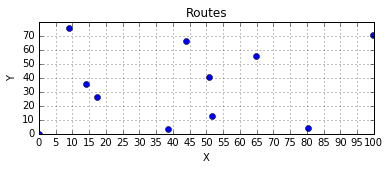

In [10]:
plot_base(df)
# plot_lines([0, 10, 50, 0], [0, 50, 10, 0])
plt.show()

### Step 1

In [11]:
'''
# distance

$D_{ij} = \sqrt{(X_{i} - X{j})^2 + (Y_{i} - Y{j})^2}$

'''
df_distance = pd.DataFrame({
    i: [np.sqrt((df.x[i] - df.x[j])**2 + (df.y[i] - df.y[j])**2) 
        for j in df.index
       ] for i in df.index
}, index=df.index, columns=df.index)

df_distance

,0,1,2,3,4,5,6,7,8,9,10
0,0.000000,38.578839,31.500351,53.170553,122.391457,79.884922,65.249417,76.218003,80.320662,85.444610,38.641897
1,38.578839,0.000000,10.135408,44.494531,92.736670,42.926975,37.312631,39.998805,73.601166,54.575691,40.986000
2,31.500351,10.135408,0.000000,37.196841,93.830712,48.384722,36.669967,49.960882,66.872545,55.901546,31.501684
3,53.170553,44.494531,37.196841,0.000000,75.602257,54.932483,28.350459,76.261333,29.752218,45.160835,16.113513
4,122.391457,92.736670,93.830712,75.602257,0.000000,56.272544,57.391762,91.017440,69.510040,38.174731,91.247401
5,79.884922,42.926975,48.384722,54.932483,56.272544,0.000000,26.981846,35.852018,72.606567,23.811848,63.847864
6,65.249417,37.312631,36.669967,28.350459,57.391762,26.981846,0.000000,54.502741,47.024019,20.355021,39.604548
7,76.218003,39.998805,49.960882,76.261333,91.017440,35.852018,54.502741,0.000000,101.003703,59.260514,78.251396
8,80.320662,73.601166,66.872545,29.752218,69.510040,72.606567,47.024019,101.003703,0.000000,53.896962,41.718257
9,85.444610,54.575691,55.901546,45.160835,38.174731,23.811848,20.355021,59.260514,53.896962,0.000000,58.705762


In [12]:
'''
# gain

$g_{ij} = D_{di} + D_{dj} - D_{ij}$

'''
n = df.shape[0]
df_gain = pd.DataFrame({
    '%s_%s' % ((i, j) if i < j else (j, i)):
        [df_distance.iloc[0, i] + 
         df_distance.iloc[0, j] - 
         df_distance.iloc[i, j]]
        for i in df.index[1:] for j in range(i,n)
        if not i == j
}).T

### Step 2

In [13]:
df_gain.sort_values(by=[0], ascending=[False], inplace=True)

assert df_gain.shape[0] == (df.shape[0]-1)*(df.shape[0]-2)/2

df_gain.head()

,0
4_9,169.661336
4_5,146.003836
5_9,141.517684
4_8,133.202080
6_9,130.339005


### Step 3

ITERATION #1

pair: 4 9
route #0
[0, 4, 9, 0]


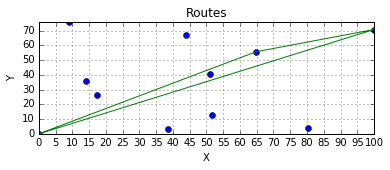

ITERATION #2

pair: 4 5
route #0
[0, 5, 4, 9, 0]


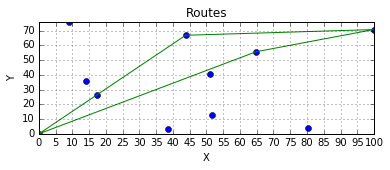

ITERATION #3

pair: 5 9
## ROUTE CONSTRAINT VIOLATED ##
route #0
[0, 5, 4, 9, 0]


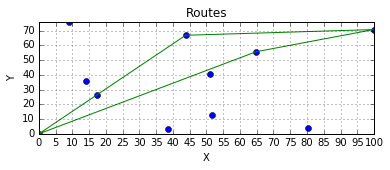

ITERATION #4

pair: 4 8
## ROUTE CONSTRAINT VIOLATED ##
route #0
[0, 5, 4, 9, 0]


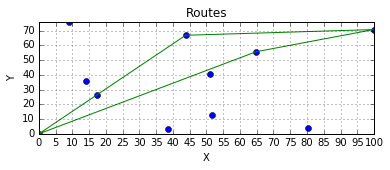

ITERATION #5

pair: 6 9
route #0
[0, 5, 4, 9, 6, 0]


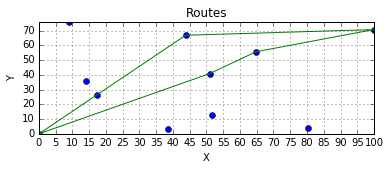

ITERATION #6

pair: 4 6
## ROUTE CONSTRAINT VIOLATED ##
route #0
[0, 5, 4, 9, 6, 0]


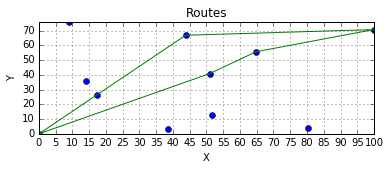

ITERATION #7

pair: 5 7
route #0
[0, 7, 5, 4, 9, 6, 0]


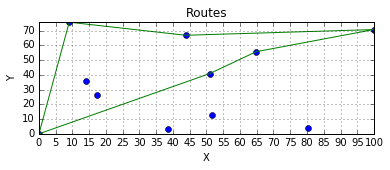

ITERATION #8

pair: 5 6
## ROUTE CONSTRAINT VIOLATED ##
route #0
[0, 7, 5, 4, 9, 6, 0]


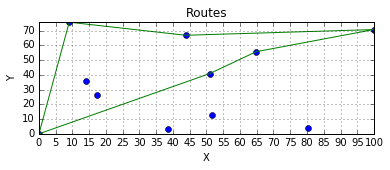

ITERATION #9

pair: 8 9
## ROUTE CONSTRAINT VIOLATED ##
route #0
[0, 7, 5, 4, 9, 6, 0]


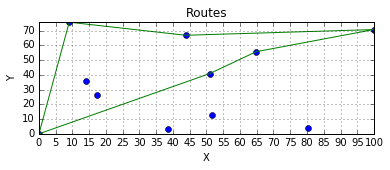

ITERATION #10

pair: 4 7
## ROUTE CONSTRAINT VIOLATED ##
route #0
[0, 7, 5, 4, 9, 6, 0]


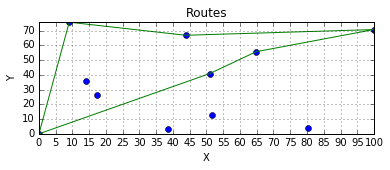

ITERATION #11

pair: 3 8
route #0
[0, 7, 5, 4, 9, 6, 0]
route #1
[0, 3, 8, 0]


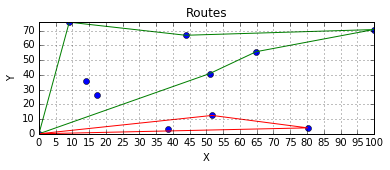

ITERATION #12

pair: 7 9
## ROUTE CONSTRAINT VIOLATED ##
route #0
[0, 7, 5, 4, 9, 6, 0]
route #1
[0, 3, 8, 0]


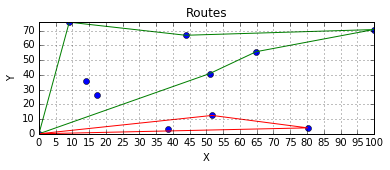

ITERATION #13

pair: 3 4
## ROUTE CONSTRAINT VIOLATED ##
route #0
[0, 7, 5, 4, 9, 6, 0]
route #1
[0, 3, 8, 0]


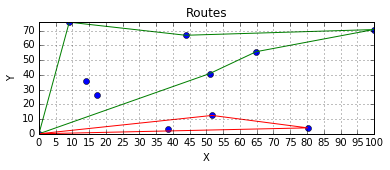

ITERATION #14

pair: 6 8
route #0
[0, 7, 5, 4, 9, 6, 8, 3, 0]


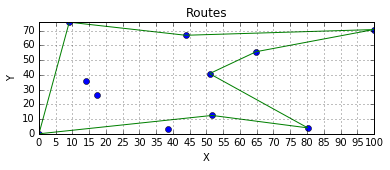

ITERATION #15

pair: 3 9
## ROUTE CONSTRAINT VIOLATED ##
route #0
[0, 7, 5, 4, 9, 6, 8, 3, 0]


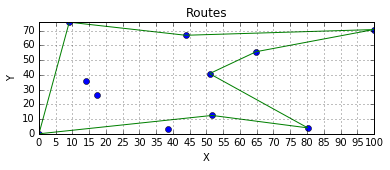

ITERATION #16

pair: 3 6
## ROUTE CONSTRAINT VIOLATED ##
route #0
[0, 7, 5, 4, 9, 6, 8, 3, 0]


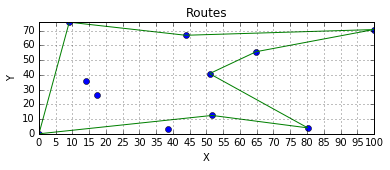

ITERATION #17

pair: 5 8
## ROUTE CONSTRAINT VIOLATED ##
route #0
[0, 7, 5, 4, 9, 6, 8, 3, 0]


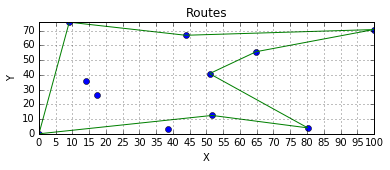

ITERATION #18

pair: 6 7
## ROUTE CONSTRAINT VIOLATED ##
route #0
[0, 7, 5, 4, 9, 6, 8, 3, 0]


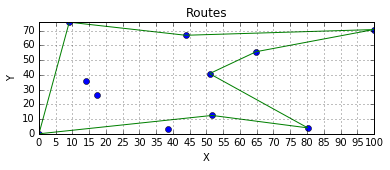

ITERATION #19

pair: 3 5
## ROUTE CONSTRAINT VIOLATED ##
route #0
[0, 7, 5, 4, 9, 6, 8, 3, 0]


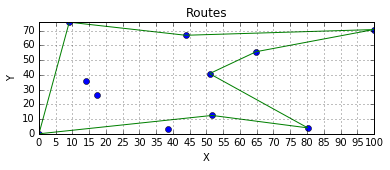

ITERATION #20

pair: 8 10
## ROUTE CONSTRAINT VIOLATED ##
route #0
[0, 7, 5, 4, 9, 6, 8, 3, 0]


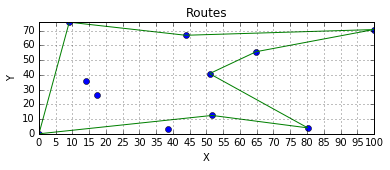

ITERATION #21

pair: 3 10
route #0
[0, 7, 5, 4, 9, 6, 8, 3, 10, 0]


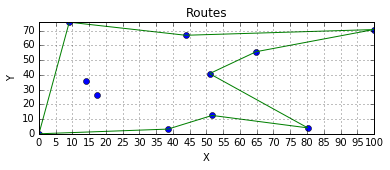

ITERATION #22

pair: 1 5
## ROUTE CONSTRAINT VIOLATED ##
route #0
[0, 7, 5, 4, 9, 6, 8, 3, 10, 0]


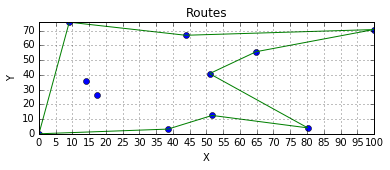

ITERATION #23

pair: 1 7
route #0
[0, 1, 7, 5, 4, 9, 6, 8, 3, 10, 0]


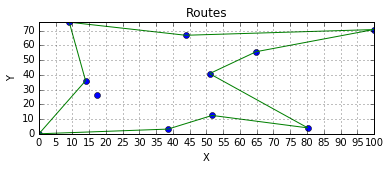

ITERATION #24

pair: 4 10
## ROUTE CONSTRAINT VIOLATED ##
route #0
[0, 1, 7, 5, 4, 9, 6, 8, 3, 10, 0]


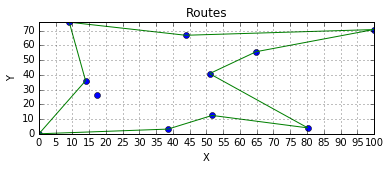

ITERATION #25

pair: 1 9
## ROUTE CONSTRAINT VIOLATED ##
route #0
[0, 1, 7, 5, 4, 9, 6, 8, 3, 10, 0]


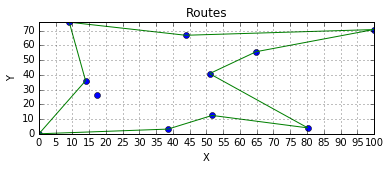

ITERATION #26

pair: 1 4
## ROUTE CONSTRAINT VIOLATED ##
route #0
[0, 1, 7, 5, 4, 9, 6, 8, 3, 10, 0]


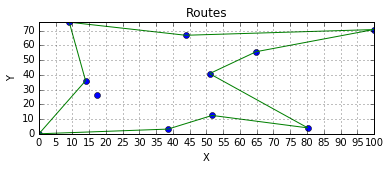

ITERATION #27

pair: 1 6
## ROUTE CONSTRAINT VIOLATED ##
route #0
[0, 1, 7, 5, 4, 9, 6, 8, 3, 10, 0]


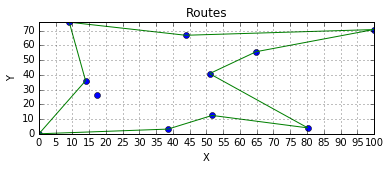

ITERATION #28

pair: 9 10
## ROUTE CONSTRAINT VIOLATED ##
route #0
[0, 1, 7, 5, 4, 9, 6, 8, 3, 10, 0]


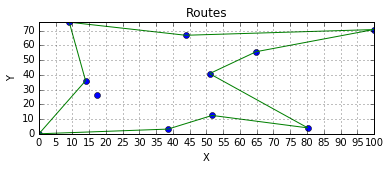

ITERATION #29

pair: 6 10
## ROUTE CONSTRAINT VIOLATED ##
route #0
[0, 1, 7, 5, 4, 9, 6, 8, 3, 10, 0]


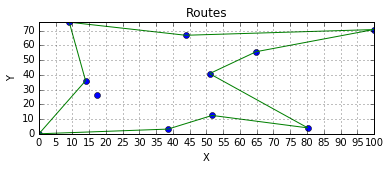

ITERATION #30

pair: 2 5
## ROUTE CONSTRAINT VIOLATED ##
route #0
[0, 1, 7, 5, 4, 9, 6, 8, 3, 10, 0]


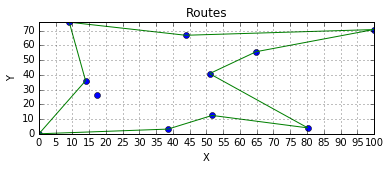

ITERATION #31

pair: 2 9
## ROUTE CONSTRAINT VIOLATED ##
route #0
[0, 1, 7, 5, 4, 9, 6, 8, 3, 10, 0]


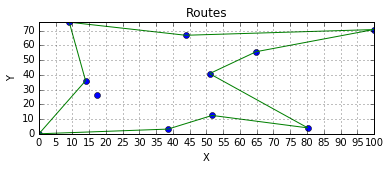

ITERATION #32

pair: 2 6
## ROUTE CONSTRAINT VIOLATED ##
route #0
[0, 1, 7, 5, 4, 9, 6, 8, 3, 10, 0]


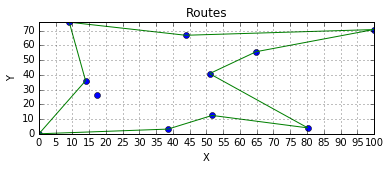

ITERATION #33

pair: 2 4
## ROUTE CONSTRAINT VIOLATED ##
route #0
[0, 1, 7, 5, 4, 9, 6, 8, 3, 10, 0]


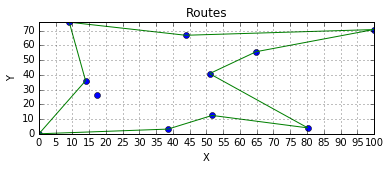

ITERATION #34

pair: 1 2
route #0
[0, 2, 1, 7, 5, 4, 9, 6, 8, 3, 10, 0]


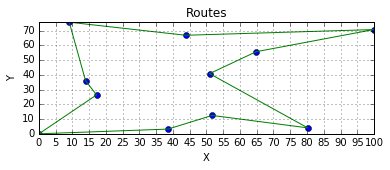

In [14]:
routes = [[]]
n_routes = 1
n_points = df.shape[0] - 1

_gain = df_gain.copy()

i = 0
while True:
    i += 1
    print('=' * 80)
    print('ITERATION #%s' % i)
    print('=' * 80, end='\n\n')
    
    k1, k2 = get_next_pair(_gain, drop=True)
    print('pair:', k1, k2)
    routes = add_node(routes, k1, k2)
    
    plot_base(df)
    for j, route in enumerate(routes):
        print('route #%s' % j)
        print(route)
        connect_points(df, route)
    plt.grid(True)
    plt.show()
    
    if check_all_points_satisfied(routes, n_points):
        break